# XOR

In [1]:
import numpy as np
from numpy.random import multivariate_normal, permutation
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
import tensorflow as tf
%matplotlib inline
np.random.seed(20170802)
tf.set_random_seed(20170802)

# ネットワーク構成のクラスを定義

In [2]:
class Network:
    def __init__(self, numUnit1,numUnit2,para):
        with tf.Graph().as_default():
            self.prepare_model(numUnit1,numUnit2,para)
            self.prepare_session()
            
    def prepare_model(self, numUnit1,numUnit2,para):
        with tf.name_scope("input") as scope:
            x = tf.placeholder(tf.float32, [None, 2], name="input")
            
        with tf.name_scope("h1") as scope:
            w1 = tf.Variable(tf.truncated_normal([2,numUnit1]),name="w1")
            b1 = tf.Variable(tf.truncated_normal([numUnit1]),name="b1")
            h1 = tf.nn.tanh(tf.matmul(x, w1)+b1,name="h1")
            
        with tf.name_scope("h2") as scope:
            w2 = tf.Variable(tf.truncated_normal([numUnit1,numUnit2]),name="w2")
            b2 = tf.Variable(tf.truncated_normal([numUnit2]),name="b2")
            h2 = tf.nn.relu(tf.matmul(h1, w2)+b2,name="h2")
            
        with tf.name_scope("out") as scope:
            w3 = tf.Variable(tf.truncated_normal([numUnit2,1]),name="w3")
            b3 = tf.Variable(tf.truncated_normal([1]),name="b3")
            out = tf.nn.sigmoid(tf.matmul(h2,w3)+b3,name="out")
            
        with tf.name_scope("Optimizer") as scope:
            ideal = tf.placeholder(tf.float32, [None, 1],name="ideal")
            loss = -tf.reduce_sum(ideal*tf.log(out) + (1-ideal)*tf.log(1-out),name="loss")
            tf.summary.scalar("cross_entropy", loss)
            #train_step = tf.train.AdamOptimizer().minimize(loss)
            train_step = tf.train.GradientDescentOptimizer(para).minimize(loss)
                               
        with tf.name_scope("Evaluator") as scope:
            correct_prediction = tf.equal(tf.sign(out-0.5),tf.sign(ideal-0.5))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            tf.summary.scalar("accuracy", accuracy)
            
        tf.summary.histogram("w1",w1)
        tf.summary.histogram("b1",b1)
        tf.summary.histogram("w2",w2)
        tf.summary.histogram("b2",b2)
        tf.summary.histogram("w3",w3)
        tf.summary.histogram("b3",b3)
        tf.summary.histogram("h1",h1)
        tf.summary.histogram("h2",h2)
        tf.summary.histogram("out",out)
            
        self.x, self.ideal, self.out = x, ideal, out
        self.train_step = train_step
        self.loss, self.accuracy = loss, accuracy
        
    def prepare_session(self):
        sess = tf.InteractiveSession()
        sess.run(tf.global_variables_initializer())
        
        summary = tf.summary.merge_all()
        writer = tf.summary.FileWriter("log2", sess.graph)
        self.sess = sess
        self.summary = summary
        self.writer = writer

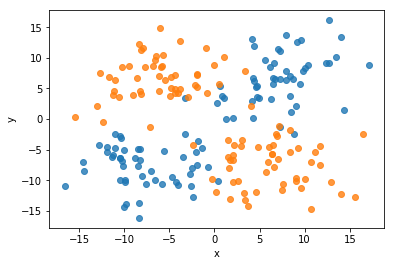

In [3]:
def generate_datablock(n, center, eyesize, label):
    data = multivariate_normal(center, np.eye(2)*eyesize, n)
    df = DataFrame(data, columns =['x','y'])
    df['l' ] = label
    return df

df0 = generate_datablock(50, [-7,-7], 15, 1)
df1 = generate_datablock(50, [7,-7], 15, 0)
df2 = generate_datablock(50, [-7,7], 15, 0)
df3 = generate_datablock(50, [7,7], 15, 1)

df = pd.concat([df0,df1,df2,df3], ignore_index=True)
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)

sns.regplot(x="x", y="y", data=df[df['l']==1],fit_reg=False)
sns.regplot(x="x", y="y", data=df[df['l']==0],fit_reg=False)

plt.show()

train_x = train_set[['x','y']].as_matrix()
train_t = train_set[['l']].as_matrix()

# 学習セッション

In [4]:
nn = Network(2,2,0.001)

In [5]:
times = 0
for _ in range(2000):
    times += 1
    nn.sess.run(nn.train_step, feed_dict = {nn.x:train_x, nn.ideal:train_t})
    if times  % 100 == 0:
        summary,loss_val, acc_val = nn.sess.run(
            [nn.summary,nn.loss, nn.accuracy], feed_dict = {nn.x:train_x, nn.ideal:train_t})
        nn.writer.add_summary(summary,times)
        print("Step: {0:d}, Loss: {1:f}, Accuracy: {2:f}".format(times, loss_val, acc_val))

Step: 100, Loss: 56.187576, Accuracy: 0.915000
Step: 200, Loss: 48.475151, Accuracy: 0.925000
Step: 300, Loss: 41.385590, Accuracy: 0.935000
Step: 400, Loss: 34.583122, Accuracy: 0.955000
Step: 500, Loss: 32.252556, Accuracy: 0.955000
Step: 600, Loss: 31.579517, Accuracy: 0.955000
Step: 700, Loss: 31.348816, Accuracy: 0.955000
Step: 800, Loss: 31.286583, Accuracy: 0.955000
Step: 900, Loss: 31.230080, Accuracy: 0.955000
Step: 1000, Loss: 30.966164, Accuracy: 0.955000
Step: 1100, Loss: 30.853775, Accuracy: 0.960000
Step: 1200, Loss: 36.368366, Accuracy: 0.945000
Step: 1300, Loss: 31.189320, Accuracy: 0.955000
Step: 1400, Loss: 30.775749, Accuracy: 0.960000
Step: 1500, Loss: 30.748695, Accuracy: 0.960000
Step: 1600, Loss: 30.773275, Accuracy: 0.960000
Step: 1700, Loss: 31.613804, Accuracy: 0.955000
Step: 1800, Loss: 30.684559, Accuracy: 0.960000
Step: 1900, Loss: 32.635246, Accuracy: 0.955000
Step: 2000, Loss: 30.706905, Accuracy: 0.955000


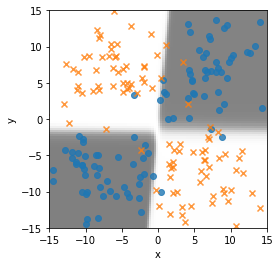

In [6]:
#train_set1 = train_set[train_set['l']==1]
#train_set1 = train_set[train_set['l']==0]

sns.regplot(x="x", y="y", data=df[df['l']==1],fit_reg=False, marker="o")
sns.regplot(x="x", y="y", data=df[df['l']==0],fit_reg=False,marker="x")

locations = []
for y1 in np.linspace(-15,15,100):
    for x1 in np.linspace(-15,15,100):
        locations.append([x1,y1])
p_vals = nn.sess.run(nn.out, feed_dict={nn.x:locations})
p_vals = p_vals.reshape((100,100))
plt.imshow(p_vals, origin='lower', extent=(-15,15,-15,15), cmap=plt.cm.gray_r, alpha = 0.5)